In [1]:
#search for import above the current directory
import sys
import os
from pathlib import Path
cwd = Path().resolve()

sys.path.insert(1, os.path.join(cwd, 'Read Process CSV'))

import numpy as np
import pandas as pd
from tqdm import tqdm
import json
from scipy import stats

import dataAnalyzer_FTStat
import dataScreen_FTStat
import orbiStandardize

#Set up the inputs

#Folder with FT Statistic-ified files. All the files need to be processed using the same metrics.
folderPath = "Orbi_120k"
SmpStd = ['Std','A'] * 3 + ['Std','F'] * 3 + ['Std'] + ['Std','K'] * 3 + ['Std','I'] * 3 + ['Std'] + ['Std','M'] * 3 + ['Std'] + ['Std','ARC'] * 3 + ['Std'] + ['Std','BTC'] * 3 + ['Std','THR1'] * 3 + ['Std'] + ['Std','AA'] * 3 + ['Std'] + ['Std','C'] * 3 + ['Std'] 
Replicate = ['1','1','2','2','3','3','4','1','1','2','2','3','3'] * 2 + ['1','1','2','2','3','3','4'] * 2

fragmentDict = {'96':['18O','D','17O','13C','Unsub']}

fragmentMostAbundant = ['Unsub']

massStr = []
fragmentIsotopeList = []
for i, v in fragmentDict.items():
    massStr.append(i)
    fragmentIsotopeList.append(v)
    
cullByTime = True
cullTimes = [(3,40)]

#Any specific properties you want to cull on
cullOn = "TIC*IT"
#Multiple of SD you want to cull beyond for the cullOn property
cull_amount = 3
#Whether you want to cull zero scans
cullZeroScans = False
#Whether you want to calculate weighted averages based on NL height (specifically designed for GC elution but widely applicable!)
weightByNLHeight = False
#Whether you want to output each file as you process it, and where you want it to go:
fileOutputPath = None

percentAbundance = False

extractedData120k = {}

rtnAllFilesDF, mergedDict, allOutputDict = dataAnalyzer_FTStat.calc_Folder_Output(folderPath, cullOn=cullOn, cullAmount=cull_amount,
                                               cullByTime=cullByTime, cullTimes = cullTimes, 
                                               fragmentIsotopeList = fragmentIsotopeList, 
                                               fragmentMostAbundant = fragmentMostAbundant, debug = True, fileExt = '.txt', 
                                               massStrList = list(fragmentDict.keys()),
                                               Microscans = 10)

failedRSE = dataScreen_FTStat.RSESNScreen(allOutputDict)
failedZero = dataScreen_FTStat.zeroCountsScreen(mergedDict, fragmentDict['96'], threshold = 0)
failedInternal = dataScreen_FTStat.internalStabilityScreenSubsequence(mergedDict, fragmentDict['96'], 'Unsub', priorSubsequenceLength = 100, testSubsequenceLength = 100, thresholdConstant = 0.64)
failedTICIT = dataScreen_FTStat.TICITScreen(mergedDict, threshold = 0.1)

fileKeys = list(mergedDict.keys())
for subKey, subData in failedRSE.items():
    failedRSE[subKey] = [fileKeys[x] for x in subData]

failedAny = {}
for subKey, subData in failedRSE.items():
    failedAny[subKey + '/Unsub'] = set(subData) | set(failedZero[subKey]) | set(failedZero['Unsub']) | set(failedInternal[subKey]) | set(failedInternal['Unsub']) | set(failedTICIT)

extractedData120k = dataAnalyzer_FTStat.folderOutputToDict(rtnAllFilesDF)

20211207_10_MPA_STD_01.txt
20211207_11_MPA_A_01.txt
20211207_12_MPA_STD_02.txt
20211207_13_MPA_A_02.txt
20211207_14_MPA_STD_03.txt
20211207_15_MPA_A_03.txt
20211207_16_MPA_STD_04.txt
20211207_17_MPA_F_01.txt
20211207_18_MPA_STD_05.txt
20211207_19_MPA_F_02.txt
20211207_20_MPA_STD_06.txt
20211207_21_MPA_F_03.txt
20211207_22_MPA_STD_07.txt
20211208_11_MPA_STD_01.txt
20211208_12_MPA_K_01.txt
20211208_13_MPA_STD_02.txt
20211208_14_MPA_K_02.txt
20211208_15_MPA_STD_03.txt
20211208_16_MPA_K_03.txt
20211208_17_MPA_STD_04.txt
20211208_18_MPA_I_01.txt
20211208_19_MPA_STD_05.txt
20211208_20_MPA_I_02.txt
20211208_21_MPA_STD_06.txt
20211208_22_MPA_I_03.txt
20211208_23_MPA_STD_04.txt
20211209_05_MPA_STD_01.txt
20211209_06_MPA_M_01.txt
20211209_07_MPA_STD_02.txt
20211209_08_MPA_M_02.txt
20211209_09_MPA_STD_03.txt
20211209_10_MPA_M_03.txt
20211209_11_MPA_STD_04.txt
20230502_08_MPA_SIG_STD_04.txt
20230502_09_MPA_ARC_SMP_01.txt
20230502_10_MPA_SIG_STD_02.txt
20230502_11_MPA_ARC_SMP_02.txt
20230502_12_MPA

In [8]:
outDict = {'13C/Unsub':[],'D/Unsub':[]}
for fileKey, fileData in mergedDict.items():
    for observedRat in ['13C/Unsub','D/Unsub']:
        thisData = fileData[0][observedRat]
        # Perform Kolmogorov-Smirnov test for normality
        kstest_result = stats.kstest(thisData, 'norm')

        #print("Kolmogorov-Smirnov test statistic:", kstest_result.statistic)
        print("p-value:", kstest_result.pvalue)

        # Perform Shapiro-Wilk test for normality
        shapiro_result = stats.shapiro(thisData)

        #print("Shapiro-Wilk test statistic:", shapiro_result.statistic)
        print("p-value:", shapiro_result.pvalue)

        outDict[observedRat].append(shapiro_result.pvalue)

p-value: 4.105678634570866e-109
p-value: 0.2204030305147171
p-value: 2.123072041039349e-107
p-value: 0.2747437655925751
p-value: 3.255416765144339e-108
p-value: 0.607022225856781
p-value: 1.772496174465902e-106
p-value: 0.8643662333488464
p-value: 1.1893590645987352e-108
p-value: 0.30759531259536743
p-value: 6.114519496259515e-107
p-value: 0.3000141382217407
p-value: 9.669084615300489e-108
p-value: 0.6912912726402283
p-value: 5.119639095141403e-106
p-value: 0.5654150247573853
p-value: 3.511486011562766e-108
p-value: 0.7190620303153992
p-value: 1.7799029264005206e-106
p-value: 0.9969978332519531
p-value: 2.561375023660119e-106
p-value: 0.7383372187614441
p-value: 1.2574870889986624e-104
p-value: 0.7575693130493164
p-value: 6.021878850185005e-108
p-value: 0.43646538257598877
p-value: 3.01652285950213e-106
p-value: 0.49176284670829773
p-value: 3.2738008156366512e-108
p-value: 0.925532341003418
p-value: 1.7071301620600324e-106
p-value: 0.22575262188911438
p-value: 6.203795970571757e-108
p-

In [15]:
import numpy as np

thisArr = np.array(outDict['13C/Unsub'])

(thisArr < 0.05).sum() / len(thisArr)


0.07462686567164178

In [14]:
np.array(outDict['13C/Unsub'])

array([2.20403031e-01, 6.07022226e-01, 3.07595313e-01, 6.91291273e-01,
       7.19062030e-01, 7.38337219e-01, 4.36465383e-01, 9.25532341e-01,
       5.50554633e-01, 5.63256204e-01, 7.42132306e-01, 1.55413628e-01,
       2.63244539e-01, 7.22994804e-01, 1.29782632e-01, 5.24004400e-01,
       5.91997989e-02, 9.17732716e-01, 7.69181609e-01, 3.39161158e-01,
       7.20569715e-02, 1.58695936e-01, 5.34621537e-01, 1.85929522e-01,
       2.79483628e-02, 1.19246796e-01, 3.26350302e-01, 2.90996492e-01,
       6.04486525e-01, 7.33004451e-01, 3.36320549e-01, 5.85377216e-01,
       1.97623700e-01, 5.97928643e-01, 1.37308566e-02, 6.14518649e-04,
       2.82076746e-01, 4.98868853e-01, 1.44226756e-02, 8.07464004e-01,
       5.84064543e-01, 4.88931417e-01, 8.39911938e-01, 2.98532486e-01,
       8.14663708e-01, 9.00720179e-01, 1.71645801e-03, 6.51180327e-01,
       3.15576673e-01, 1.04871064e-01, 2.78767139e-01, 3.61786485e-01,
       1.95111424e-01, 4.50277627e-01, 6.34466648e-01, 5.40587604e-01,
      

In [17]:
np.array(outDict['13C/Unsub']) < 0.05

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False,  True,  True,
       False, False,  True, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False])

In [18]:
np.array(outDict['D/Unsub']) < 0.05

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False])

In [2]:
meanL = []
serrL = []
xs = []
withinErr = []
for i in range(1000):
    obs = np.random.normal(1,0.1,size = 3)
    serr = obs.std() / np.sqrt(1)
    mean = obs.mean()
    meanL.append(mean)
    serrL.append(serr)
    xs.append(np.random.uniform())

    if np.abs(1 - mean) < serr:
        withinErr.append(1)
    else:
        withinErr.append(0)

In [3]:
np.array(withinErr).sum()

699

In [4]:
np.array(serrL).mean()

0.07095795843407905

In [5]:
np.array(mean).mean()

1.0188663687204504

<ErrorbarContainer object of 3 artists>

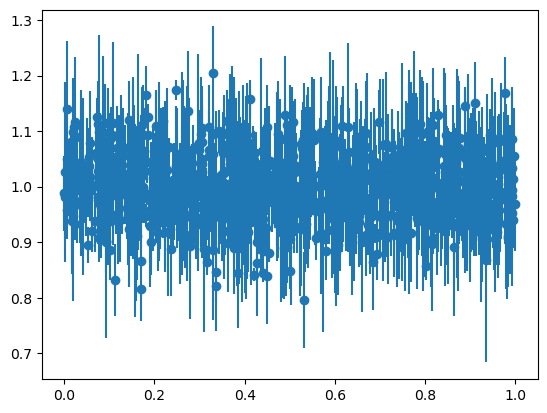

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.errorbar(xs, meanL, yerr = serrL, fmt = 'o')

In [7]:
checkThresholdConstant = False
if checkThresholdConstant:
    maxes = []
    for i in tqdm(range(1000)):
        array = np.random.normal(size = 4570)

        # Reshape the array into a 2D array with 10 columns
        num_rows = 4570 // 10
        reshaped_array = array[:num_rows * 10].reshape(num_rows, 10)

        # Calculate the average along axis 1 (columns)
        averages = np.mean(reshaped_array, axis=1)

        outlier = dataScreen_FTStat.subsequenceOutlierDetection(pd.Series(averages), priorSubsequenceLength = 100, testSubsequenceLength = 100)
        maxes.append(outlier.max())

    np.array(maxes).mean() + 4 * np.array(maxes).std()

In [9]:
checkTIC = True
if checkTIC:
    for thisSmp in ['A','F','K','I','M','C','ARC','BTC','THR1','AA']:
        firstIdx = SmpStd.index(thisSmp)
        thisSmpIndices = [firstIdx, firstIdx + 2, firstIdx + 4]
        thisStdIndices = [firstIdx-1, firstIdx +1, firstIdx + 3, firstIdx +5]

        allSmpTic = []
        for smpIdx in thisSmpIndices:
            smpName = list(mergedDict.keys())[smpIdx]
            thisDf = mergedDict[smpName][0]
            allSmpTic += list(thisDf['tic'])

        allStdTic = []
        for stdIdx in thisStdIndices:
            stdName = list(mergedDict.keys())[stdIdx]
            thisDf = mergedDict[stdName][0]
            allStdTic += list(thisDf['tic'])

        smpTic = np.array(allSmpTic)
        stdTic = np.array(allStdTic)
        print(thisSmp + ' ' + f'{smpTic.mean():.2f}' + ' ' + f'{smpTic.std() / smpTic.mean():.2f}')
        print( f'{stdTic.mean():.2f}' + ' ' + f'{stdTic.std() / stdTic.mean():.2f}')

A 150491589.48 0.03
142291044.18 0.04
F 143577777.90 0.04
135800595.19 0.03
K 124044606.51 0.04
128149034.96 0.04
I 122146054.92 0.04
123529122.08 0.03
M 108591118.74 0.05
95748827.99 0.07
C 59241140.80 0.04
60950258.91 0.06
ARC 66609479.53 0.11
63432060.62 0.16
BTC 74288095.93 0.07
73661375.78 0.21
THR1 72429239.52 0.14
73358017.33 0.25
AA 119148324.16 0.04
118904299.33 0.04


In [ ]:
byIndex = {}
bySample = {}
for thisSmp in ['A','F','K','I','M','C','ARC','BTC','THR1','AA']:
    bySample[thisSmp] = {}
    firstIdx = SmpStd.index(thisSmp)
    thisIndices = list(range(firstIdx -1, firstIdx + 6))
    byIndex[thisSmp] = thisIndices

    for ratioKey in ['13C/Unsub','D/Unsub']:
        valDict = orbiStandardize.extractThisRun(extractedData120k, failedAny, thisIndices, ratioKey)
        vals, errs = orbiStandardize.standardizeOneRun(valDict['Avg'], valDict['RelStdError'], standardize = 'linear')
        deltas = 1000*(vals-1)

        bySample[thisSmp][ratioKey] = {}
        bySample[thisSmp][ratioKey]['Raw Ratios'] = list(valDict['Avg'])
        bySample[thisSmp][ratioKey]['Raw RSE'] = list(valDict['RelStdError'])
        bySample[thisSmp][ratioKey]['Ratios'] = list(vals)
        bySample[thisSmp][ratioKey]['RSEs'] = list(errs)
        bySample[thisSmp][ratioKey]['Deltas'] = list(deltas)
        bySample[thisSmp][ratioKey]['DeltasErr'] = list(1000*errs)
        bySample[thisSmp][ratioKey]['Delta Mean'] = deltas.mean()
        bySample[thisSmp][ratioKey]['ER'] = deltas.std()

with open('120k_Data.json', 'w', encoding='utf-8') as f:
    json.dump(bySample, f, ensure_ascii=False, indent=4)

In [ ]:
import basicDeltaOperations as op

In [ ]:
x = op.deltaToConcentration('H', -235)
x[1] / (x[0] + x[1]) * 10**6

119.14220344394955